In [112]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
print(tf.__version__)

2.12.0


In [ ]:
tf.config.get_visible_devices()

In [113]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2023-06-04 11:57:29--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolvendo user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Conectando-se a user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 34146 (33K) [image/png]
Salvando em: “original.png”

original.png        100%[===================>]  33.35K  --.-KB/s    em 0.002s  

2023-06-04 11:57:29 (13.8 MB/s) - “original.png” salvo [34146/34146]



In [114]:
# Declaring Constants
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [115]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [144]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)


In [117]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


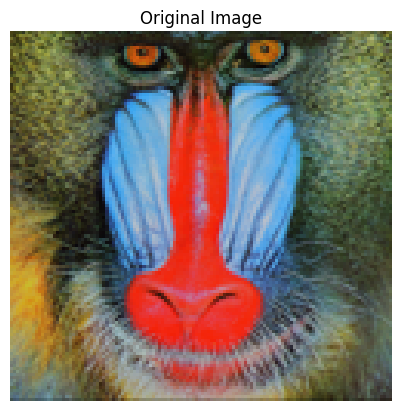

In [118]:
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [119]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.071207


Saved as Super Resolution.jpg


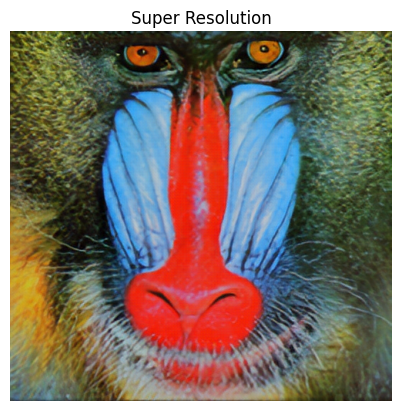

In [120]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [123]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O white_wolf.jpg
IMAGE_PATH = "white_wolf.jpg"

--2023-06-04 12:01:23--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolvendo lh4.googleusercontent.com (lh4.googleusercontent.com)... 172.217.13.97
Conectando-se a lh4.googleusercontent.com (lh4.googleusercontent.com)|172.217.13.97|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 84897 (83K) [image/jpeg]
Salvando em: “white_wolf.jpg”

white_wolf.jpg      100%[===================>]  82.91K  --.-KB/s    em 0.03s   

2023-06-04 12:01:23 (2.47 MB/s) - “white_wolf.jpg” salvo [84897/84897]



In [124]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

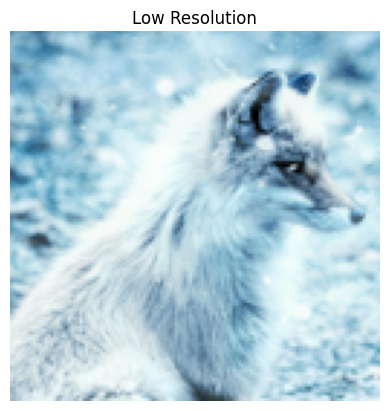

In [127]:
hr_image = preprocess_image(IMAGE_PATH)
lr_image = downscale_image(tf.squeeze(hr_image))
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [128]:
model = hub.load(SAVED_MODEL_PATH)

In [129]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.107481


PSNR Achieved: nan


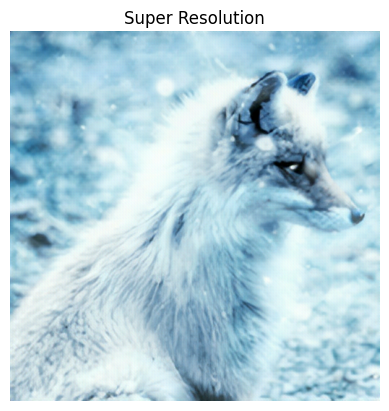

In [134]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 205),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: nan


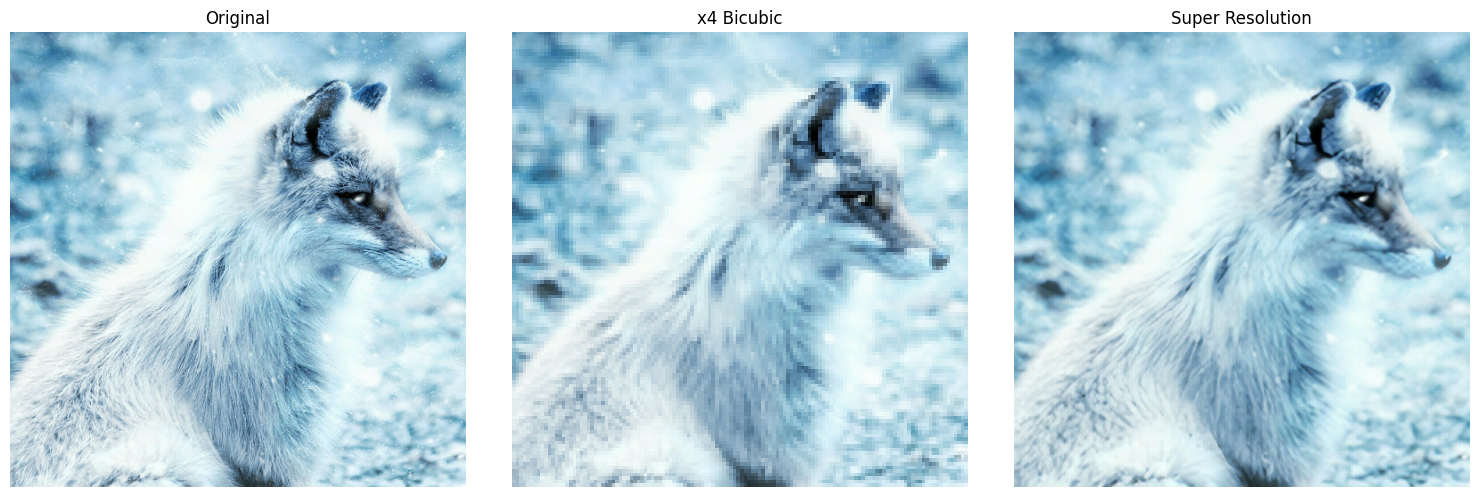

In [145]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
# tensorflowjs_converter --signature_name=serving_default   --input_format=tf_hub https://tfhub.dev/captain-pool/esrgan-tf2/1 ./src/assets/improve_resolution